In [9]:
# !pip install pandas matplotlib numpy

In [10]:
import os
from pathlib import Path

from plotter import *
from plotter.epochstats import EpochStats
from plotter.plotselectivities import PlotSelectivities, PlotSelectivitiesRangeQuery
from plotter.dataclass import SelectivityVsMetric, SelectivityVsRangeQueryMetric
from plotter.utils import vanilla_dirname, rqdc_dirname

PROJECT_DIR = Path.cwd().parent.parent

In [11]:
experiments_to_plot = list()

for lb, ub in LOWER_UPPER_BOUNDS:
    for selectivity in SELECTIVITY:
        experiments_to_plot.append({
            "inserts": INSERTS,
            "updates": UPDATES,
            "range": RANGE_QUERIES,
            "selectivity": selectivity,
            "sizeRatio": SIZE_RATIO,
            "entrySize": ENTRY_SIZE,
            "entriesPerPage": ENTRIES_PER_PAGE,
            "numPagesPerFile": NUM_PAGE_PER_FILE,
            "lowerBound": lb,
            "upperBound": ub,
        })

In [12]:
stats_for_different_selectivities = dict()
stats_for_different_selectivities_rq = dict()

for exp in experiments_to_plot:
    selectivity = exp['selectivity']
    EXPDIRNAME = f"{PROJECT_DIR}/.vstats/experiments-{TAG}-E{ENTRY_SIZE}-B{ENTRIES_PER_PAGE}-S{RANGE_QUERIES}-Y{selectivity}-T{SIZE_RATIO}"
    vandirpath = os.path.join(EXPDIRNAME, vanilla_dirname(exp))
    rqdcdirpath = os.path.join(EXPDIRNAME, rqdc_dirname(exp))
    rqdcdirpath_overlapping_rq = os.path.join(EXPDIRNAME, rqdc_dirname(exp, 0, OVERLAPPING_RANGE_QUERY_COUNT))
    rqdcdirpath_overlapping_rq_per = os.path.join(EXPDIRNAME, rqdc_dirname(exp, 0, OVERLAPPING_RANGE_QUERY_COUNT, OVERLAPPING_RQ_PERCENT))
    
    filesize = exp["entrySize"] * exp["entriesPerPage"] * exp["numPagesPerFile"]

    van = EpochStats(vandirpath, NUMEPOCHS, filesize)
    rqdc = EpochStats(rqdcdirpath, NUMEPOCHS, filesize)
    rqdc1 = EpochStats(rqdcdirpath_overlapping_rq, NUMEPOCHS, filesize)
    rqdc2 = EpochStats(rqdcdirpath_overlapping_rq_per, NUMEPOCHS, filesize)
    stats_for_different_selectivities[selectivity] = SelectivityVsMetric(
        Vanilla=van.get_plotstats()[0],
        RangeReduce=rqdc.get_plotstats()[0],
        RangeReduceSameRQ=rqdc1.get_plotstats()[0],
        RangeReduceOverlappingRQ=rqdc2.get_plotstats()[0],
    )

    stats_for_different_selectivities_rq[selectivity] = SelectivityVsRangeQueryMetric(
        Vanilla=van.get_rangequerystats(),
        RangeReduce=rqdc.get_rangequerystats(),
        RangeReduceSameRQ=rqdc1.get_rangequerystats(),
        RangeReduceOverlappingRQ=rqdc2.get_rangequerystats(),
    )

/Users/shubham/SSD Lab/LSMQueryDrivenCompaction/src/.notebooks/plotter/epochstats.py:262: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self._rangequery_stats = self._rangequery_stats.applymap(
/Users/shubham/SSD Lab/LSMQueryDrivenCompaction/src/.notebooks/plotter/epochstats.py:262: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self._rangequery_stats = self._rangequery_stats.applymap(
/Users/shubham/SSD Lab/LSMQueryDrivenCompaction/src/.notebooks/plotter/epochstats.py:262: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self._rangequery_stats = self._rangequery_stats.applymap(
/Users/shubham/SSD Lab/LSMQueryDrivenCompaction/src/.notebooks/plotter/epochstats.py:262: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self._rangequery_stats = self._rangequery_stats.applymap(
/Users/shubham/SSD Lab/LSMQueryDrivenCompaction/src/.notebooks/plotter/e

In [13]:
plot_selectivities = PlotSelectivities(stats_for_different_selectivities)

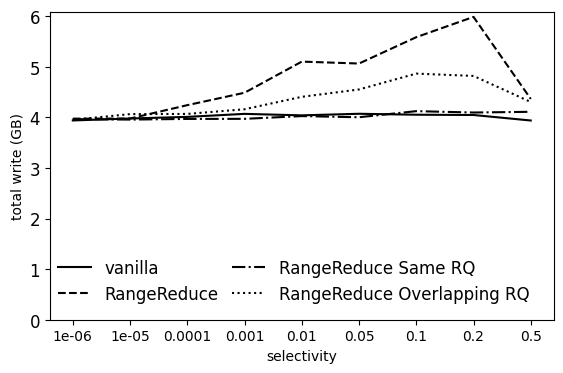

In [14]:
plot_selectivities.plot_total_bytes_written()

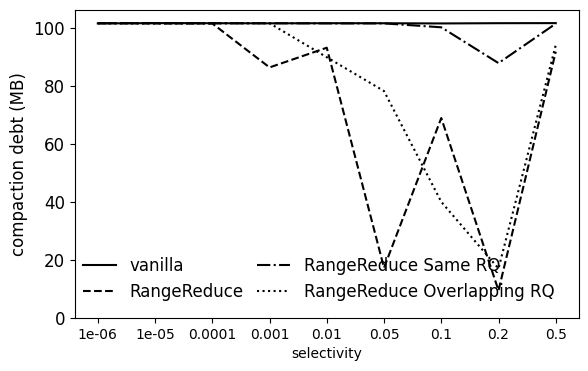

In [15]:
plot_selectivities.plot_compaction_debt()

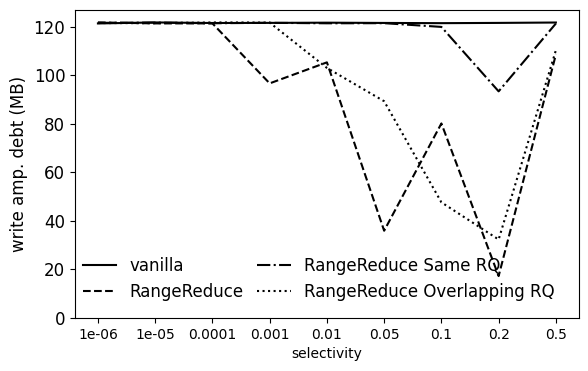

In [16]:
plot_selectivities.plot_write_amp_debt()

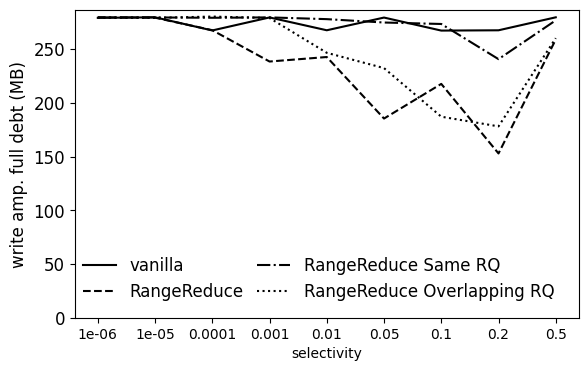

In [17]:
plot_selectivities.plot_write_amp_full_debt()

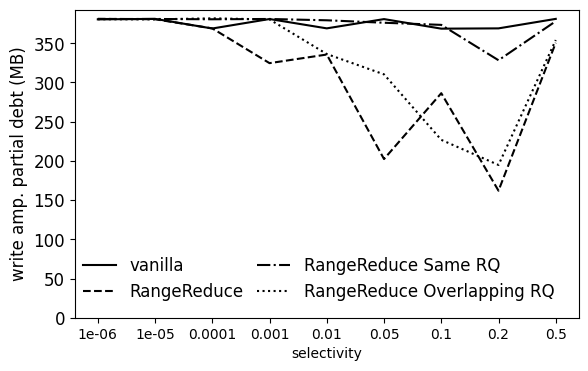

In [18]:
plot_selectivities.plot_write_amp_partial_debt()

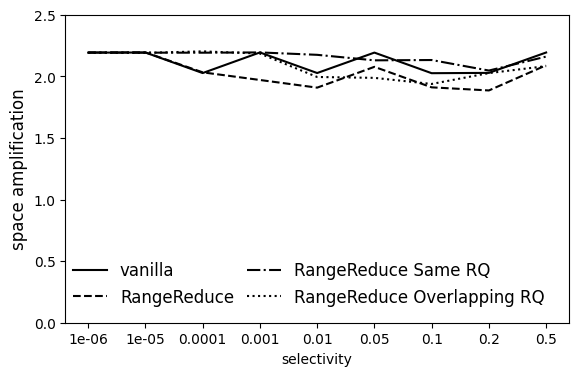

In [19]:
plot_selectivities.plot_space_amplification()

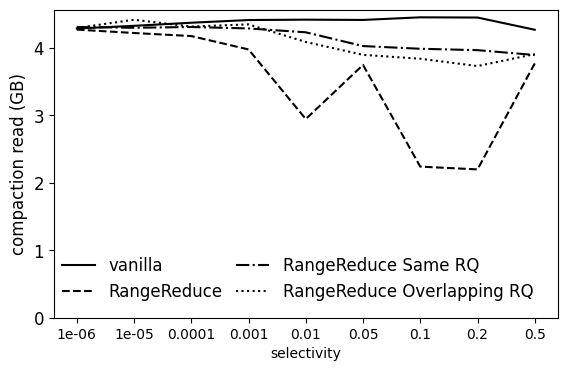

In [20]:
plot_selectivities.plot_compaction_read()

In [21]:
plot_selectivities_rq = PlotSelectivitiesRangeQuery(stats_for_different_selectivities_rq)

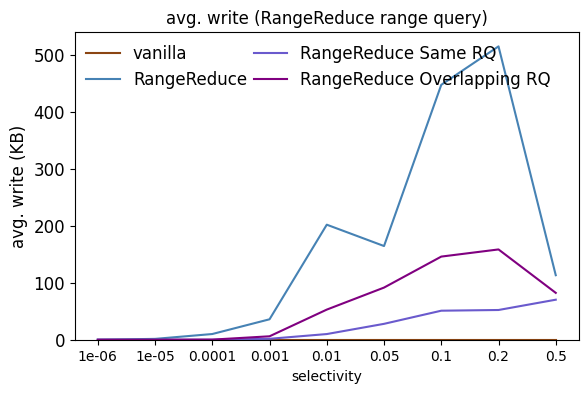

In [22]:
plot_selectivities_rq.avg_bytes_written_for_range_queries()

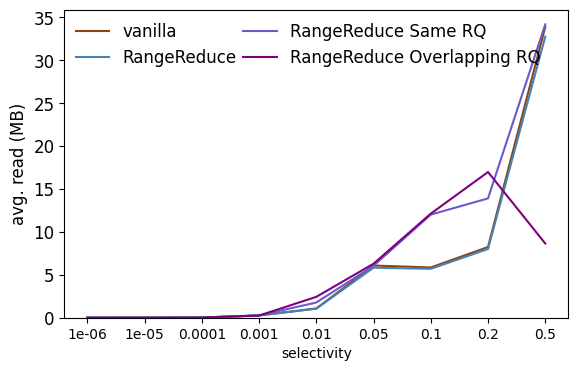

In [23]:
plot_selectivities_rq.avg_bytes_read_for_range_queries()

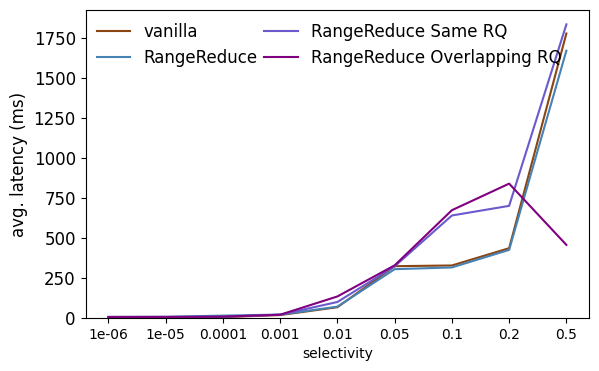

In [24]:
plot_selectivities_rq.avg_latency_for_range_queries()

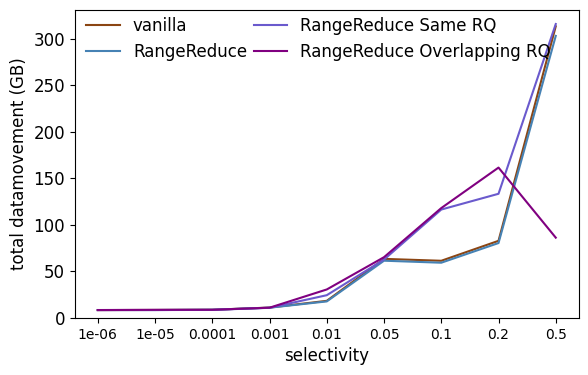

In [25]:
PlotSelectivities.plot_total_data_movement(stats_for_different_selectivities, stats_for_different_selectivities_rq)